In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')


The dataset we'll be using comprises information about songs released during the last 100 years. Along with some general information on songs, scientific sound metrics such as loudness, acoustics, speechiness, and so on are also provided.

In [2]:
songs_data = pd.read_csv('dataset.csv')
songs_data.shape

(114000, 18)

Data cleaning is a critical step without which data will be useless since raw data has a lot of noise that must be cleaned or else the observations produced from it will be wrong and the model's performance will be poor. Outlier removal, null value imputation, and data skewness correction are all steps in the data cleaning process. To clean the data first we observe the information of the data we have.

In [3]:
songs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   track_name        113999 non-null  object 
 3   artists           113999 non-null  object 
 4   track_genre       114000 non-null  object 
 5   duration_ms       114000 non-null  int64  
 6   popularity        114000 non-null  int64  
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           11

Lets observe if there are any null values present in the columns of our data frame.

In [4]:
songs_data.isnull().sum()


id                  0
track_id            0
track_name          1
artists             1
track_genre         0
duration_ms         0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
dtype: int64

We can observe that album name and track name has null values we will remove such rows with null values.

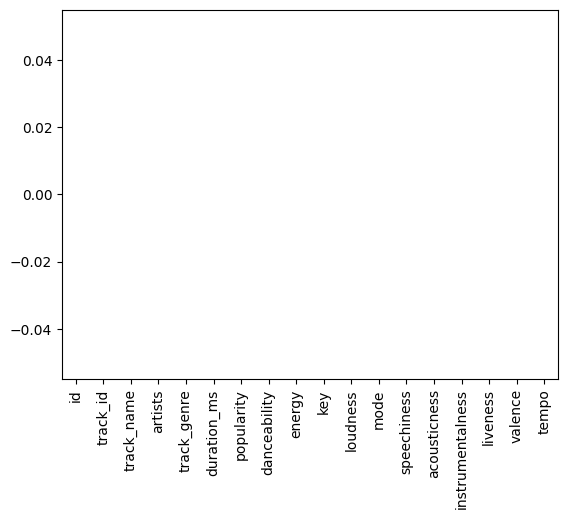

In [5]:
songs_data.dropna(inplace = True)
songs_data.isnull().sum().plot.bar()
plt.show()

The next step is to remove some columns which we won’t be using to build our recommender system.

In [6]:
songs_data = songs_data.drop(['track_id'], axis = 1)
songs_data.head(1)

,id,track_name,artists,track_genre,duration_ms,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,Comedy,Gen Hoshino,acoustic,230666,73,0.676,0.461,1,-6.746,0,0.143,0.0322,0.000001,0.358,0.715,87.917


We need to count of rows in the DataFrame that are duplicates of previous rows, indicating how many duplicated rows are present in the DataFrame.

In [7]:
songs_data.duplicated().sum()

0

In genre column, we are removing mandopop genre since the track name of that particular genre is not clear

In [8]:

# List of names to remove
names_to_remove = ['mandopop']

# Create a boolean mask to identify rows with names to remove
mask = songs_data['track_genre'].isin(names_to_remove)

# Invert the mask to keep rows that do not match the names to remove
songs_data = songs_data[~mask]

songs_data

,id,track_name,artists,track_genre,duration_ms,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,Comedy,Gen Hoshino,acoustic,230666,73,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917
1,1,Ghost - Acoustic,Ben Woodward,acoustic,149610,55,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489
2,2,To Begin Again,Ingrid Michaelson;ZAYN,acoustic,210826,57,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332
3,3,Can't Help Falling In Love,Kina Grannis,acoustic,201933,71,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740
4,4,Hold On,Chord Overstreet,acoustic,198853,82,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,113995,Sleep My Little Boy,Rainy Lullaby,world-music,384999,21,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995
113996,113996,Water Into Light,Rainy Lullaby,world-music,385000,22,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239
113997,113997,Miss Perfumado,Cesária Evora,world-music,271466,22,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378
113998,113998,Friends,Michael W. Smith,world-music,283893,41,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960


Removing rows in which non english track names are present 

In [9]:
import pandas as pd
import string

def contains_non_english(text):
    return any(char not in string.printable for char in text)

column_name = 'track_name'  # Replace with the actual column name

# Create a boolean mask for rows containing non-English text
non_english_mask = songs_data[column_name].apply(contains_non_english)

# Remove rows containing non-English text from the DataFrame
cleaned_data = songs_data[~non_english_mask]

removed_rows = songs_data[non_english_mask]
print("Removed rows:")
print(removed_rows.head(2))

songs_data = cleaned_data


Removed rows:
      id            track_name             artists track_genre  duration_ms  \
51    51               透明だった世界       Motohiro Hata    acoustic       232360   
106  106  なんでもないや - movie ver.  Mone Kamishiraishi    acoustic       349920   

     popularity  danceability  energy  key  loudness  mode  speechiness  \
51           61         0.373   0.914    0    -4.185     1       0.0565   
106          49         0.357   0.161    8   -10.667     1       0.0388   

     acousticness  instrumentalness  liveness  valence    tempo  
51          0.076          0.000000     0.669    0.560  168.210  
106         0.971          0.000014     0.358    0.325   83.449  


It is also necessary to remove unnecessary information that is present in brackets in track_name coloumn

In [10]:

# Function to remove brackets and content within them
def remove_brackets(name):
    return name.split(' (')[0]

songs_data['track_name'] = songs_data['track_name'].apply(remove_brackets)

songs_data


,id,track_name,artists,track_genre,duration_ms,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,Comedy,Gen Hoshino,acoustic,230666,73,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917
1,1,Ghost - Acoustic,Ben Woodward,acoustic,149610,55,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489
2,2,To Begin Again,Ingrid Michaelson;ZAYN,acoustic,210826,57,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332
3,3,Can't Help Falling In Love,Kina Grannis,acoustic,201933,71,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740
4,4,Hold On,Chord Overstreet,acoustic,198853,82,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,113995,Sleep My Little Boy,Rainy Lullaby,world-music,384999,21,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995
113996,113996,Water Into Light,Rainy Lullaby,world-music,385000,22,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239
113997,113997,Miss Perfumado,Cesária Evora,world-music,271466,22,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378
113998,113998,Friends,Michael W. Smith,world-music,283893,41,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960


We now eliminate all of its duplicate rows, and just the first occurrence of each unique set of data is kept.

In [11]:
songs_data= songs_data.drop_duplicates()
subset_columns = ['track_name']
songs_data.drop_duplicates(subset=subset_columns, inplace=True)

Let us examine how many songs we have once we have eliminated duplicates.

In [12]:
songs_data.shape

(59925, 17)

In [13]:
floats = []
for col in songs_data.columns:
    if songs_data[col].dtype == 'float':
    	floats.append(col)

len(floats)

9

There is a total of 9 columns with float values in them. Let’s draw their distribution plot to get insights into the distribution of the data.

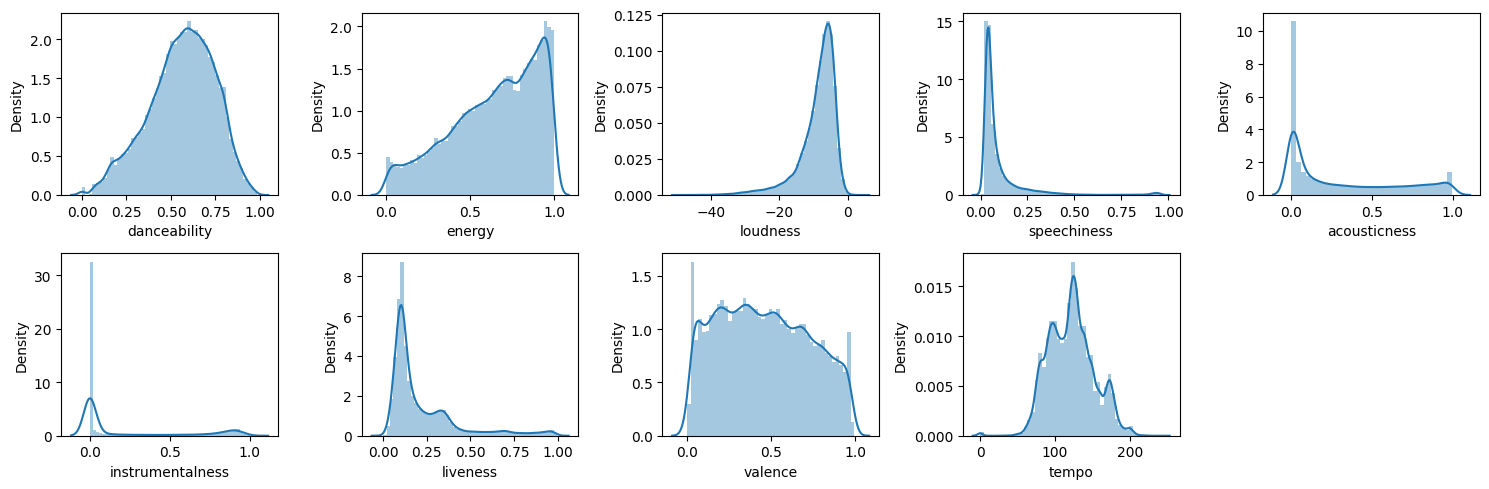

In [14]:
plt.subplots(figsize = (15, 5))
for i, col in enumerate(floats):
  plt.subplot(2, 5, i + 1)
  sb.distplot(songs_data[col])
plt.tight_layout()
plt.show()

Some of the features have normal distribution while some data distribution is skewed as well.

Incorporating the 'tags' column is a strategic approach to enhance song recommendations by capturing and utilizing more specific characteristics of each song. By combining genre and artist information, the recommendation system can offer personalized suggestions that align more closely with users' musical tastes and preferences.

In [15]:
songs_data['track_genre1'] = songs_data['track_genre'].apply(lambda x: x.replace(' ', ''))
songs_data['artists1'] = songs_data['artists'].apply(lambda x: x.replace(' ', ''))

In [16]:
songs_data['tags'] = songs_data['track_genre1'] + ','+songs_data['artists1'] 

We will drop unnecessary coloumns which are not necessary for recommending songs

In [17]:
songs_data =  songs_data.drop(columns=['artists1','track_genre1','duration_ms','danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo'])

In [18]:
songs_data

,id,track_name,artists,track_genre,popularity,tags
0,0,Comedy,Gen Hoshino,acoustic,73,"acoustic,GenHoshino"
1,1,Ghost - Acoustic,Ben Woodward,acoustic,55,"acoustic,BenWoodward"
2,2,To Begin Again,Ingrid Michaelson;ZAYN,acoustic,57,"acoustic,IngridMichaelson;ZAYN"
3,3,Can't Help Falling In Love,Kina Grannis,acoustic,71,"acoustic,KinaGrannis"
4,4,Hold On,Chord Overstreet,acoustic,82,"acoustic,ChordOverstreet"
...,...,...,...,...,...,...
113993,113993,How Can I Keep From Singing,Chris Tomlin,world-music,39,"world-music,ChrisTomlin"
113995,113995,Sleep My Little Boy,Rainy Lullaby,world-music,21,"world-music,RainyLullaby"
113996,113996,Water Into Light,Rainy Lullaby,world-music,22,"world-music,RainyLullaby"
113997,113997,Miss Perfumado,Cesária Evora,world-music,22,"world-music,CesáriaEvora"


Because the dataset is too vast, the computation cost/time will be too high, so we will demonstrate the implementation of the recommended system using the top 10,000 songs

In [19]:
songs_data = songs_data.sort_values(by=['popularity'], ascending=False).head(10000)
songs_data = songs_data.reset_index(drop=True)

In [20]:
print(songs_data)

          id                             track_name  \
0      20001                                 Unholy   
1      51664  Quevedo: Bzrp Music Sessions, Vol. 52   
2      67356                             La Bachata   
3      20008                               I'm Good   
4      67358                        Me Porto Bonito   
...      ...                                    ...   
9995   44822                          I Am the Fire   
9996  106310                       Forget to Forget   
9997     610                     Fortune - Acoustic   
9998    9045                             Tudo Posso   
9999   36304                                  Ville   

                         artists track_genre  popularity  \
0           Sam Smith;Kim Petras       dance         100   
1               Bizarrap;Quevedo     hip-hop          99   
2                  Manuel Turizo       latin          98   
3        David Guetta;Bebe Rexha       dance          98   
4     Bad Bunny;Chencho Corleone       

CountVectorizer plays a pivotal role in converting text data into a format suitable for machine learning algorithms. It enables efficient processing and analysis of textual information, making it a valuable tool for various NLP applications.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [22]:
vector = cv.fit_transform(songs_data['tags']).toarray()

In [23]:
vector.shape

(10000, 6091)

This function calculates the similarity between an input song and all other songs in the dataset using textual and numeric features. Here we are using cosine similarity. cosine similarity can be used to find similar items (in this case, songs) based on the feature vectors.

In [24]:

similarity = cosine_similarity(vector)


In [25]:
similarity


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [26]:

def recommend(song):
    index = songs_data[songs_data['track_name'] == song].index[0]
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:6]:
        print("song name:",songs_data.iloc[i[0]].track_name,",","artist name:",songs_data.iloc[i[0]].artists, "genre:",songs_data.iloc[i[0]].track_genre )

 If the input song name is not found in the dataset (songs_data), prints a message indicating that the song is not popular or the name is invalid, then suggesting songs from the dataset using similarity factor as alternatives.

In [27]:
def recommend_songs(song_name, data=songs_data):
# Base case
    if songs_data[songs_data['track_name'] == song_name].shape[0] == 0:
    	print('This song is either not so popular or you have entered invalid_name.\n Some songs you may like:\n')
	
    	for song in data.sample(n=5)['track_name'].values:
        	print(song)
    	return

    data['similarity_factor'] = recommend(song_name)

    data.sort_values(by=['similarity_factor', 'popularity'],ascending = [False, False],inplace=True)



Let's check which tracks the recommender system would suggest if he/she listens to the renowned song "Khairiyat"

In [28]:
recommend_songs("Khairiyat")

song name: Shayad , artist name: Pritam;Arijit Singh genre: indian
song name: Raabta , artist name: Pritam;Arijit Singh genre: indian
song name: Kalank , artist name: Pritam;Arijit Singh genre: indian
song name: Channa Mereya , artist name: Pritam;Arijit Singh genre: indian
song name: Ae Dil Hai Mushkil Title Track , artist name: Pritam;Arijit Singh genre: indian


Below shown is the case if the song name is not present in list or not popular.

In [29]:
recommend_songs("Sleep My Little Boy")

This song is either not so popular or you have entered invalid_name.
 Some songs you may like:

Quand je te vois
Tu Jaane Na
Forever After All
Someone You Loved - Piano Version
ICE COLD
